<a href="https://colab.research.google.com/github/Tawheed-DS/Book-Recommendation-System/blob/main/Tawheed_Project_II(_NB3).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##<b>Book Recommendation System</b>

###Data description

###Dataset comprises of three files:

* <b>Users dataframe</b>
Contains the users. Note that user IDs (User-ID) have been anonymized and map to
integers. Demographic data is provided (Location, Age) if available. Otherwise, these
fields contain NULL values.

* <b>Books dataframe</b>
Books are identified by their respective ISBN. Invalid ISBNs have already been removed
from the dataset. Moreover, some content-based information is given (Book-Title,
Book-Author, Year-Of-Publication, Publisher), obtained from Amazon Web
Services. Note that in the case of several authors, only the first is provided. URLs linking
to cover images are also given, appearing in three different flavors (Image-URL-S,
Image-URL-M, Image-URL-L), i.e., small, medium, large. These URLs point to the
Amazon website.

* <b>Ratings dataframe</b>
Contains the book rating information. Ratings (Book-Rating) are either explicit,
expressed on a scale from 1-10 (higher values denoting higher appreciation), or implicit,
expressed by 0.

In [19]:
# Import all the required libraries

import numpy as np 
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

import scipy
import math
import random
import sklearn
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from scipy.sparse.linalg import svds

%matplotlib inline

# Just for ease
p = print

In [20]:
# Mount the drive

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [21]:
# Load the dataframes

user_df = pd.read_csv('/content/drive/MyDrive/Copy of Users.csv')
books_df = pd.read_csv('/content/drive/MyDrive/Copy of Books.csv')
ratings_df = pd.read_csv('/content/drive/MyDrive/Copy of Ratings.csv')

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (3) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [22]:
# Top rows and shape of user_df
p(user_df.head())
p('shape: ',user_df.shape)

   User-ID                            Location   Age
0        1                  nyc, new york, usa   NaN
1        2           stockton, california, usa  18.0
2        3     moscow, yukon territory, russia   NaN
3        4           porto, v.n.gaia, portugal  17.0
4        5  farnborough, hants, united kingdom   NaN
shape:  (278858, 3)


In [23]:
# Check null values
user_df.isnull().sum()

User-ID          0
Location         0
Age         110762
dtype: int64

###<b>Handling null values in Age</b>

In [24]:
# Null values in age column
nulls = sum(user_df['Age'].isnull())
p('Null values in Age: ',nulls)

Null values in Age:  110762


In [25]:
# Replacing null values
median = user_df['Age'].median()
std = user_df['Age'].std()
random_age = np.random.randint(median - std, median + std, size = nulls)
age = user_df['Age'].copy()
age[pd.isnull(age)] = random_age
user_df['Age'] = age
user_df['Age'] = user_df['Age'].astype(int)

In [26]:
sum(user_df['Age'].isnull())

0

###<b>Handling Outliers in Age</b>

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


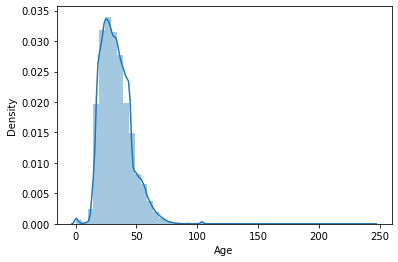

In [27]:
# Plot Distribution of Age
sns.distplot(user_df['Age'].dropna())

In [28]:
# Number of outliers
outliers = sum(user_df['Age']>90)
p(outliers)

430


In [29]:
# Handling outliers by randomly replacing age >90 by values between 90 and 100
age2 = user_df['Age'].copy()
random_age2 = np.random.randint(90,100,outliers)
age2[user_df['Age']>90]=random_age2
user_df['Age'] = age2

In [30]:
# Review the unique values
user_df['Age'].unique()

array([39, 18, 27, 17, 37, 61, 40, 30, 36, 26, 14, 45, 20, 42, 19, 25, 46,
       32, 55, 24, 34, 23, 28, 51, 41, 31, 21, 44, 22, 57, 43, 33, 38, 54,
       50, 29, 53, 47, 35, 13, 58, 49, 62, 63, 66, 15, 60,  0, 79, 16, 65,
       59, 48, 72, 56, 67,  1, 80, 52, 69, 71, 73, 78,  9, 64, 96, 90, 12,
       74, 75, 94,  3, 76, 83, 68, 98, 97, 92, 11, 77,  2, 93, 70, 91,  8,
        7,  4, 81, 10,  5, 99, 95,  6, 84, 82, 85, 86, 87, 89, 88])

###<b> EDA and Data Wrangling</b>

In [31]:
# Number of users in total
p('Number of users: ',user_df.shape)

Number of users:  (278858, 3)


In [32]:
# Number of instances of books in book_df (along with duplicates)
books_df.shape

(271360, 8)

In [33]:
# Create age groups using age column
bins = [-1,12,20,50,100]
labels = ['Kid','Teenager','Adult','Old']
user_df['age_bins'] = pd.cut(x=user_df['Age'], bins=bins,labels=labels)

In [34]:
# Merge the above dataframe with books_df to carry on EDA using
new_df = pd.merge(user_df,ratings_df,on='User-ID')
new_df = pd.merge(new_df,books_df,on='ISBN')

In [35]:
# Check null values in new dataframe
new_df.isnull().sum()

User-ID                0
Location               0
Age                    0
age_bins               0
ISBN                   0
Book-Rating            0
Book-Title             0
Book-Author            1
Year-Of-Publication    0
Publisher              2
Image-URL-S            0
Image-URL-M            0
Image-URL-L            4
dtype: int64

In [36]:
# Clean nulls from Authors and publishers
new_df[['Book-Author','Publisher']] = new_df[['Book-Author','Publisher']].fillna('unknown')

In [37]:
# Drop columns containing URLs
new_df.drop(['Image-URL-S','Image-URL-M','Image-URL-L'],inplace=True,axis=1)

In [38]:
new_df.isnull().sum()

User-ID                0
Location               0
Age                    0
age_bins               0
ISBN                   0
Book-Rating            0
Book-Title             0
Book-Author            0
Year-Of-Publication    0
Publisher              0
dtype: int64

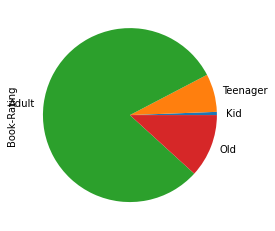

In [39]:
# Age group that rated books the most
new_df.groupby('age_bins')['Book-Rating'].count().plot(kind='pie')

In [40]:
# Most popular books for different age groups
age_bin_df = new_df.groupby(['age_bins','Book-Title'])['Book-Rating'].count().sort_values(ascending=False).reset_index()
age_bin_df.rename(columns={'Book-Title':'Number of times rated'})

,age_bins,Number of times rated,Book-Rating
0,Adult,Wild Animus,1922
1,Adult,The Lovely Bones: A Novel,1082
2,Adult,The Nanny Diaries: A Novel,729
3,Adult,The Da Vinci Code,715
4,Adult,Bridget Jones's Diary,714
...,...,...,...
964279,Teenager,Una Pena En Observacion,0
964280,Teenager,Una Nueva Generacion Dicta Las Reglas,0
964281,Teenager,Una Noche Con Sabrina Love,0
964282,Teenager,Una Navidad Diferente,0


In [41]:
# Most popular books for adults
age_bin_df[age_bin_df['age_bins']=='Adult'].head(20)

,age_bins,Book-Title,Book-Rating
0,Adult,Wild Animus,1922
1,Adult,The Lovely Bones: A Novel,1082
2,Adult,The Nanny Diaries: A Novel,729
3,Adult,The Da Vinci Code,715
4,Adult,Bridget Jones's Diary,714
5,Adult,A Painted House,671
6,Adult,The Secret Life of Bees,643
7,Adult,Divine Secrets of the Ya-Ya Sisterhood: A Novel,632
8,Adult,The Red Tent (Bestselling Backlist),609
9,Adult,Life of Pi,558


In [42]:
# Most popular books for Teens
age_bin_df[age_bin_df['age_bins']=='Teenager'].head(20)

,age_bins,Book-Title,Book-Rating
84,Teenager,Wild Animus,293
753,Teenager,The Lovely Bones: A Novel,93
964,Teenager,The Catcher in the Rye,78
1065,Teenager,Harry Potter and the Chamber of Secrets (Book 2),73
1107,Teenager,To Kill a Mockingbird,72
1151,Teenager,Harry Potter and the Sorcerer's Stone (Harry P...,70
1356,Teenager,Fahrenheit 451,63
1456,Teenager,Harry Potter and the Goblet of Fire (Book 4),60
1465,Teenager,Interview with the Vampire,60
1566,Teenager,Harry Potter and the Prisoner of Azkaban (Book 3),57


In [43]:
# Most popular books for Kids
age_bin_df[age_bin_df['age_bins']=='Kid'].head(20)

,age_bins,Book-Title,Book-Rating
12627,Kid,Harry Potter and the Sorcerer's Stone (Harry P...,12
19136,Kid,The Bad Beginning (A Series of Unfortunate Eve...,8
20042,Kid,Captain Underpants and the Invasion of the Inc...,8
24485,Kid,Harry Potter and the Chamber of Secrets (Book 2),7
25042,Kid,Harry Potter and the Goblet of Fire (Book 4),6
27704,Kid,"Night of the Living Dummy II (Goosebumps, No 31)",6
28082,Kid,Wild Animus,6
28424,Kid,Tales of a Fourth Grade Nothing,6
28537,Kid,"Artemis Fowl (Artemis Fowl, Book 1)",6
28881,Kid,"Stay Out of the Basement (Goosebumps, No 2)",6


In [44]:
# Most popular books for Old users
age_bin_df[age_bin_df['age_bins']=='Old'].head(20)

,age_bins,Book-Title,Book-Rating
91,Old,Wild Animus,281
431,Old,The Da Vinci Code,135
533,Old,The Lovely Bones: A Novel,115
585,Old,A Painted House,110
729,Old,Angels &amp; Demons,95
835,Old,The Secret Life of Bees,87
853,Old,The Summons,86
876,Old,The King of Torts,84
914,Old,The Runaway Jury,82
1022,Old,The Testament,75


In [45]:
# Check which age group gave the most implicit ratings
new_df[new_df['Book-Rating']==0]['age_bins'].value_counts()

Adult       522792
Old          78787
Teenager     41841
Kid           3874
Name: age_bins, dtype: int64

####<b>Note: </b>
####Users from each age category can be said to have some similar book preferences, we will later use Age as a relevance to recommend books for implicit ratings.

In [46]:
# Extract countries for users
new_df['country']= new_df.apply(lambda x: x['Location'].rsplit(' ')[-1],axis=1)

In [47]:
# Location can be dropped now
new_df.drop(['Location'],axis=1,inplace=True)

In [48]:
# Which country rates books the most
b1 = new_df.groupby('country')['Book-Rating'].count().sort_values(ascending=False).head(5)
b1

country
usa          746467
canada        93001
kingdom       33072
germany       27657
australia     18238
Name: Book-Rating, dtype: int64

In [49]:
# implicit rating(=0) is more frequent than explicit rating overall
new_df['Book-Rating'].value_counts()

0     647294
8      91804
10     71225
7      66402
9      60778
5      45355
6      31687
4       7617
3       5118
2       2375
1       1481
Name: Book-Rating, dtype: int64

In [50]:
# Implicit ratings i.e. Book-Rating = 0
b2 = new_df[new_df['Book-Rating']==0].\
groupby('country')['Book-Rating'].count().sort_values(ascending=False).head(5)

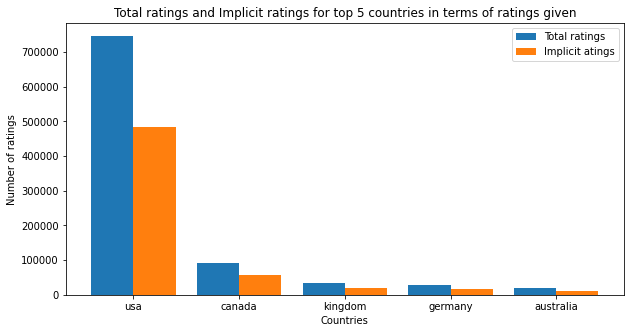

In [51]:
# Bar plot for Rating comparison 
n= 5
X_axis = np.arange(n)
X = b1.index

plt.figure(figsize=(10,5))  
plt.bar(X_axis - 0.2, b1, 0.4, label = 'Total ratings')
plt.bar(X_axis + 0.2, b2, 0.4, label = 'Implicit atings')
  
plt.xticks(X_axis, X)
plt.xlabel("Countries")
plt.ylabel("Number of ratings")
plt.title("Total ratings and Implicit ratings for top 5 countries in terms of ratings given")
plt.legend()
plt.show()

Text(0.5, 1.0, 'Books that received most ratings')

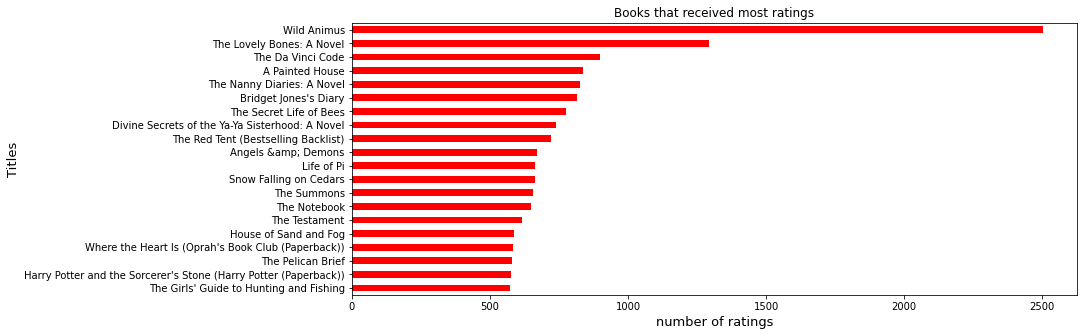

In [52]:
# Plot for ratings received by books
plt.figure(figsize=(13,5))
ax =new_df.groupby('Book-Title')['Book-Rating'].count().sort_values(ascending=False).head(20).plot(kind='barh',color='r')
ax.invert_yaxis()
plt.xlabel('number of ratings',fontdict={'size':13})
plt.ylabel('Titles',fontdict={'size':13})
plt.title('Books that received most ratings')

Text(0.5, 1.0, 'Publishers that received the most ratings')

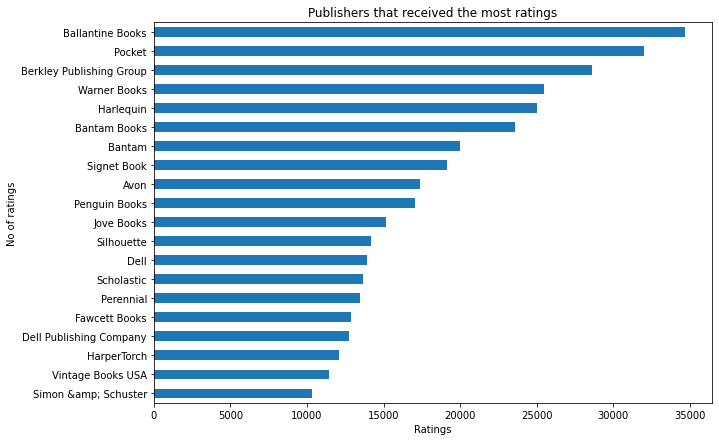

In [53]:
# Same as above for publishers
plt.figure(figsize=(10,7))
ax1 = new_df.groupby('Publisher')['Book-Rating'].count().sort_values(ascending=False).head(20).plot(kind='barh')
ax1.invert_yaxis()
plt.xlabel('Ratings')
plt.ylabel('No of ratings')
plt.title('Publishers that received the most ratings')

Text(0.5, 1.0, 'Books which were rated as 10 the most')

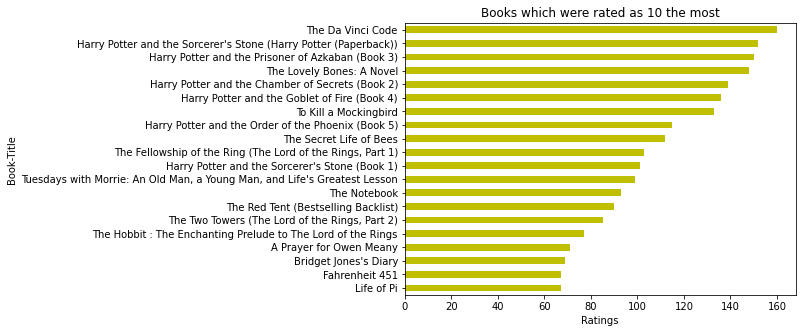

In [54]:
# Book rated as 10 by most
plt.figure(figsize=(7,5))
ax2 = new_df[new_df['Book-Rating']==10].groupby('Book-Title')['Book-Rating'].count().sort_values(ascending=False).head(20).plot(kind='barh',color='y')
ax2.invert_yaxis()
plt.xlabel('Ratings')
plt.title('Books which were rated as 10 the most')

Text(0.5, 1.0, 'Number of books from top publishers')

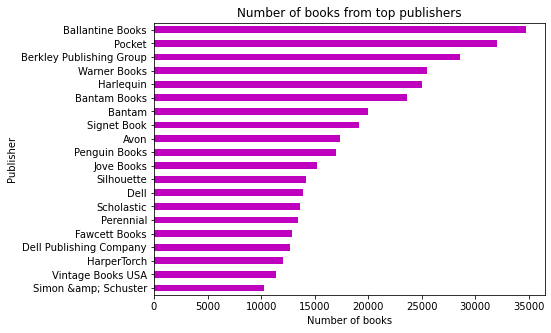

In [55]:
# Top 20 Publishers with highest book count
plt.figure(figsize=(7,5))
ax3 = new_df.groupby('Publisher')['ISBN'].count().sort_values(ascending=False).head(20).plot(kind='barh',color='m')
ax3.invert_yaxis()
plt.xlabel('Number of books')
plt.title('Number of books from top publishers')

In [56]:
# Get only those books which have been rated more than 200 times
x = new_df.groupby('Book-Title')['Book-Rating'].count()>200

Text(0.5, 1.0, 'Book vs Average Rating')

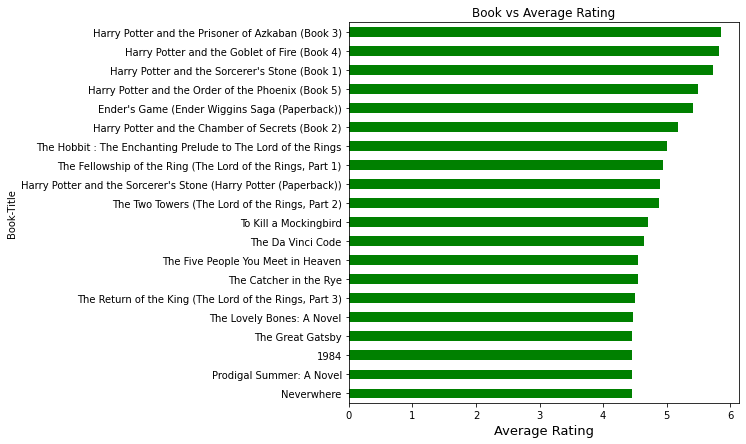

In [57]:
#Plot top rated books on an average 
plt.figure(figsize=(7,7))
ax3 = new_df[new_df['Book-Title'].isin(x[x].index)].groupby('Book-Title')\
           ['Book-Rating'].mean().sort_values(ascending=False).head(20).plot(kind='barh',color='g')
ax3.invert_yaxis()
ax3.set_xlabel('Average Rating',fontdict={'size':13})
ax3.set_title('Book vs Average Rating')

Text(0.5, 1.0, 'Publisher vs Average Rating')

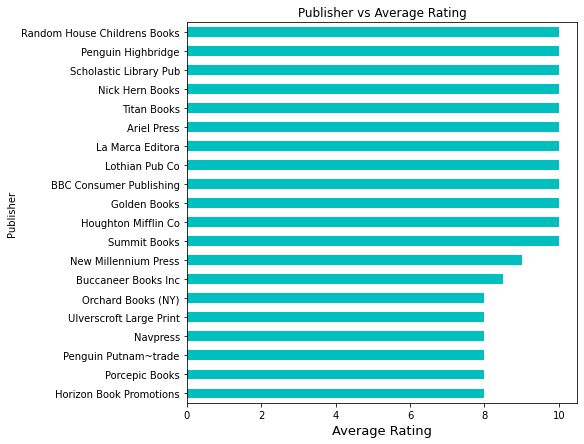

In [58]:
# Top Rated publishers on an average
plt.figure(figsize=(7,7))
ax3 = new_df[new_df['Book-Title'].isin(x[x].index)].groupby('Publisher')\
           ['Book-Rating'].mean().sort_values(ascending=False).head(20).plot(kind='barh',color='c')
ax3.invert_yaxis()
ax3.set_xlabel('Average Rating',fontdict={'size':13})
ax3.set_title('Publisher vs Average Rating')

In [59]:
new_df.shape

(1031136, 10)

In [60]:
new_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1031136 entries, 0 to 1031135
Data columns (total 10 columns):
 #   Column               Non-Null Count    Dtype   
---  ------               --------------    -----   
 0   User-ID              1031136 non-null  int64   
 1   Age                  1031136 non-null  int64   
 2   age_bins             1031136 non-null  category
 3   ISBN                 1031136 non-null  object  
 4   Book-Rating          1031136 non-null  int64   
 5   Book-Title           1031136 non-null  object  
 6   Book-Author          1031136 non-null  object  
 7   Year-Of-Publication  1031136 non-null  object  
 8   Publisher            1031136 non-null  object  
 9   country              1031136 non-null  object  
dtypes: category(1), int64(3), object(6)
memory usage: 79.7+ MB


##Data Wrangling on Books dataframe

In [61]:
# Number of books initially
books_df.shape

(271360, 8)

In [62]:
# Take only required features
books_df = books_df.loc[:,'ISBN':'Publisher']
books_df.shape

(271360, 5)

In [63]:
# Check null values
books_df.isnull().sum()

ISBN                   0
Book-Title             0
Book-Author            1
Year-Of-Publication    0
Publisher              2
dtype: int64

In [64]:
# Handling Nulls
books_df[['Book-Author','Publisher']] = books_df[['Book-Author','Publisher']].fillna('unknown')

In [65]:
p(books_df.isnull().sum())
p('Number of books: ',books_df.shape[0])

ISBN                   0
Book-Title             0
Book-Author            0
Year-Of-Publication    0
Publisher              0
dtype: int64
Number of books:  271360


In [66]:
books_df.head()

,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher
0,0195153448,Classical Mythology,Mark P. O. Morford,2002,Oxford University Press
1,0002005018,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada
2,0060973129,Decision in Normandy,Carlo D'Este,1991,HarperPerennial
3,0374157065,Flu: The Story of the Great Influenza Pandemic...,Gina Bari Kolata,1999,Farrar Straus Giroux
4,0393045218,The Mummies of Urumchi,E. J. W. Barber,1999,W. W. Norton &amp; Company


In [67]:
# More than one ISBN for some titles
p('Number of unique ISBNs: ',books_df['ISBN'].nunique())
p('Number of unique book titles: ',books_df['Book-Title'].nunique())

Number of unique ISBNs:  271360
Number of unique book titles:  242135


In [68]:
# Number of times titles are repeated
books_df.groupby(['Book-Title'])['Book-Title'].count().sort_values(ascending=False)

Book-Title
Selected Poems                                                                                                27
Little Women                                                                                                  24
Wuthering Heights                                                                                             21
Dracula                                                                                                       20
Adventures of Huckleberry Finn                                                                                20
                                                                                                              ..
Secrets of a Perfect Night: Scandalous Lord Dere/ The Last Love Letter/ Now and Forever                        1
Secrets of a Nun: My Own Story                                                                                 1
Secrets of a Natural Menopause: A Positive Drug-Free Approach (Llewellyn's Health and

####Let's try to see why some Books are repeated

In [69]:
# Selected Poems title
books_df[books_df['Book-Title']== 'Selected Poems']

,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher
4523,081120958X,Selected Poems,William Carlos Williams,1985,New Directions Publishing Corporation
39416,0811201465,Selected Poems,K. Patchen,1957,New Directions Publishing Corporation
41316,0679750800,Selected Poems,Rita Dove,1993,Vintage Books USA
106885,0060931744,Selected Poems,Gwendolyn Brooks,1999,Perennial
118775,0517101548,Selected Poems,John Donne,1994,Gramercy Books
127462,0520012984,Selected Poems,Paul Verlaine,1970,University of California Press
156894,0871401541,Selected Poems,E. E. Cummings,1994,Liveright Publishing Corporation
158312,0060909897,Selected Poems,Gwendolyn Brooks,1963,Harpercollins
175602,0571050190,Selected Poems,T. T Gunn,1962,Farrar Straus &amp; Giroux
183908,1550651498,Selected Poems,Ralph Gustafson,2001,Vehicule Press


In [70]:
# Little women title
books_df[books_df['Book-Title']== 'Little Women']

,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher
3952,185854176X,Little Women,Louisa M. Atcott,1995,Brimax Books Ltd
4330,0861782356,Little Women,Louisa May Alcott,0,Octopus Publising Group Plc
12227,0590203509,Little Women,Louisa May Alcott,1994,Scholastic
20676,0440447682,Little Women,Louisa May Alcott,1990,Yearling Books
32837,1550134140,Little Women,Louisa May Alcott,0,Firefly Books Ltd
52210,0451529308,Little Women,Louisa May Alcott,2004,Signet Classics
52551,0451518144,Little Women,Louisa May Alcott,1983,Signet Book
53358,0590437976,Little Women,Louisa May Alcott,1992,Scholastic
57432,0195813898,Little Women,Alcott,1985,Oxford University Press
72168,0785788727,Little Women,Louisa May Alcott,1999,Sagebrush Bound


In [71]:
# Wuthering heights title
books_df[books_df['Book-Title']== 'Wuthering Heights']

,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher
993,0553212583,Wuthering Heights,EMILY BRONTE,1983,Bantam
1050,0553211412,Wuthering Heights,Emily Bronte,1983,Bantam
2075,0812505166,Wuthering Heights,Emily Bronte,1989,Tor Classics
11120,0553210211,Wuthering Heights,Emily Bronte,1981,Bantam Books
12735,0439228913,Wuthering Heights,Emily Bronte,2003,Scholastic Paperbacks
13684,1566193087,Wuthering Heights,Emily Bronte,1994,Dorset Press
27658,0590460307,Wuthering Heights,Emily Bronte,1992,Scholastic Paperbacks (Mm)
29712,0140171002,Wuthering Heights,Emily Bronte,1992,Penguin Books Ltd
41500,0880299185,Wuthering Heights,Emily Bronte,1992,Barnes &amp; Noble
63570,0451519582,Wuthering Heights,Emily Bronte,1959,Signet Book


In [72]:
# Dracula title
books_df[books_df['Book-Title']== 'Dracula']

,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher
2959,156619301X,Dracula,Bram Stoker,1994,Dorset Press
5332,055321148X,Dracula,Bram Stoker,1983,Bantam
12753,9875021245,Dracula,Bram Stoker,2004,Distal
12988,0140052801,Dracula,Bram Stoker,1992,Penguin USA
52115,0451175816,Dracula,Bram Stoker,1992,New Amer Library Classics
61616,0880299010,Dracula,Bram Stoker,1992,Barnes Noble Books
68981,8481301183,Dracula,Bram Stocker,2001,Colleccion Millenium
72472,1562542621,Dracula,Emily Hutchinson,1998,"Saddleback Publishing, Inc."
82829,0515053473,Dracula,Bram Stoker,1979,Berkley Pub Group (Mm)
92499,0863221432,Dracula,Bram Stoker,1992,Brandon/Mount Eagle


###Observations:
####Some books occur more than once because they are different editions of the same books while others have similar names but different authors.

###Dealing with the duplications

In [73]:
# Define a function to combine to columns namely title and author
def change_title(str1,str2):
  '''Change the title of books'''
  str1 = str1 +" "+'by' +" "+str2
  return str1

In [74]:
# Create a new column for title
books_df['new_title'] = books_df.apply(lambda x : change_title(x['Book-Title'],x['Book-Author']),axis = 1)

In [75]:
books_df.head(2)

,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher,new_title
0,0195153448,Classical Mythology,Mark P. O. Morford,2002,Oxford University Press,Classical Mythology by Mark P. O. Morford
1,0002005018,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada,Clara Callan by Richard Bruce Wright


####Now the duplications can be removed using new_titles.

In [76]:
# Get rid of duplications
new_book_df = books_df.drop_duplicates(subset='new_title',keep='first')

In [77]:
# No more duplications
new_book_df.groupby(['new_title'])['new_title'].count().sort_values(ascending=False)

new_title
Ã?Â?thique en toc by Didier Daeninckx                                                                                        1
Harriet Tubman : The Road to Freedom (Easy Biographies) by Rae Bains                                                         1
Harriet Tubman (Christian Library) by C. Grant                                                                               1
Harriet Tubman (Childhood Of Famous Americans) by Kathleen Kudlinski                                                         1
Harriet Spies Again by HELEN ERICSON                                                                                         1
                                                                                                                            ..
Silver Wings, Santiago Blue by Janet Dailey                                                                                  1
Silver Wings (Grace Livingston Hill #37) by Grace L. Hill                                            

In [78]:
# Duplicate book title but different Authors
new_book_df[new_book_df['Book-Title']== 'Dinosaurs']

,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher,new_title
31065,0307040399,Dinosaurs,Big Color Bk,1993,Golden Books,Dinosaurs by Big Color Bk
117372,1855013150,Dinosaurs,Michael Benton,0,Tiger Books Intl,Dinosaurs by Michael Benton
117424,0860201260,Dinosaurs,Anne McCord,1988,Educational Development Corporation,Dinosaurs by Anne McCord
117606,0806966262,Dinosaurs,L. B. Halstead,1987,Sterling Pub Co Inc,Dinosaurs by L. B. Halstead
117626,072141107X,Dinosaurs,Colin Douglas,1987,Ladybird Books,Dinosaurs by Colin Douglas
117942,0836210042,Dinosaurs,Paul Lipari,1996,Andrews McMeel Publishing,Dinosaurs by Paul Lipari
118104,0906710324,Dinosaurs,Big Chief I-Spy,1996,Ravette Publishing Ltd,Dinosaurs by Big Chief I-Spy
124215,0307030539,Dinosaurs,Golden Books,1993,Golden Books,Dinosaurs by Golden Books
175194,0694006211,Dinosaurs,Byron Barton,1996,HarperFestival,Dinosaurs by Byron Barton
229068,0307039137,Dinosaurs,Kathleen N. Daly,1977,Merrigold Press,Dinosaurs by Kathleen N. Daly


In [79]:
books_df.shape,new_book_df.shape

((271360, 6), (251185, 6))

In [80]:
271360-251185

20175

In [81]:
# Choose only required columns and rename new_title column
new_book_df = new_book_df[['ISBN','new_title']].rename(columns={'new_title':'Title'})
new_book_df.head(2)

,ISBN,Title
0,0195153448,Classical Mythology by Mark P. O. Morford
1,0002005018,Clara Callan by Richard Bruce Wright


In [82]:
# A look at ratings dataframe
p(ratings_df.head())
p('shape: ',ratings_df.shape)

   User-ID        ISBN  Book-Rating
0   276725  034545104X            0
1   276726  0155061224            5
2   276727  0446520802            0
3   276729  052165615X            3
4   276729  0521795028            6
shape:  (1149780, 3)


In [83]:
ratings_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1149780 entries, 0 to 1149779
Data columns (total 3 columns):
 #   Column       Non-Null Count    Dtype 
---  ------       --------------    ----- 
 0   User-ID      1149780 non-null  int64 
 1   ISBN         1149780 non-null  object
 2   Book-Rating  1149780 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 26.3+ MB


In [84]:
# Merge Books data and ratings data into a single Dataframe
books_ratings_df = pd.merge(new_book_df,ratings_df,on='ISBN')
books_ratings_df

,ISBN,Title,User-ID,Book-Rating
0,0195153448,Classical Mythology by Mark P. O. Morford,2,0
1,0002005018,Clara Callan by Richard Bruce Wright,8,5
2,0002005018,Clara Callan by Richard Bruce Wright,11400,0
3,0002005018,Clara Callan by Richard Bruce Wright,11676,8
4,0002005018,Clara Callan by Richard Bruce Wright,41385,0
...,...,...,...,...
916928,0449906736,Flashpoints: Promise and Peril in a New World ...,276313,5
916929,0525447644,From One to One Hundred by Teri Sloat,276579,4
916930,006008667X,Lily Dale : The True Story of the Town that Ta...,276680,0
916931,0192126040,Republic (World's Classics) by Plato,276680,0


In [85]:
# Choose only explicitly rated books (Rating>0)
new_ratings_df = books_ratings_df[books_ratings_df['Book-Rating']>0]

In [86]:
# Each book has been rated these number of times
new_ratings_df.groupby('Title')['Book-Rating'].count().sort_values(ascending = False)

Title
The Lovely Bones: A Novel by Alice Sebold                                                                                    707
Wild Animus by Rich Shapero                                                                                                  581
The Da Vinci Code by Dan Brown                                                                                               487
The Red Tent (Bestselling Backlist) by Anita Diamant                                                                         383
Divine Secrets of the Ya-Ya Sisterhood: A Novel by Rebecca Wells                                                             320
                                                                                                                            ... 
Prophecies : Lost Slayer Serial novel Part 1 by Christopher Golden                                                             1
Prophecies: Visions of the World's Fate : Truths, Possibilities, or Fallacies? by Hans Holz

In [87]:
# Create a data frame for number of times each book was rated
rating_num_df = new_ratings_df.groupby('Title')['Book-Rating'].count().reset_index()
rating_num_df.rename(columns= {'Book-Rating':'Number_of_times_rated'},inplace=True)
rating_num_df

,Title,Number_of_times_rated
0,A Light in the Storm: The Civil War Diary of ...,1
1,"Ask Lily (Young Women of Faith: Lily Series, ...",1
2,Dark Justice by Jack Higgins,1
3,Earth Prayers From around the World: 365 Pray...,7
4,Final Fantasy Anthology: Official Strategy Gu...,2
...,...,...
137555,Ã?Â?bernachten mit Stil. Die schÃ?Â¶nsten Coun...,1
137556,Ã?Â?rger mit Produkt X. Roman. by Joan Aiken,3
137557,Ã?Â?sterlich leben. by Anselm GrÃ?Â¼n,1
137558,Ã?Â?stlich der Berge. by David Guterson,1


In [88]:
# Merge the above data frame with new_ratings_df
temp_df = pd.merge(new_ratings_df,rating_num_df,on='Title')
temp_df.sort_values(by='Number_of_times_rated',ascending=False)

,ISBN,Title,User-ID,Book-Rating,Number_of_times_rated
10362,0316666343,The Lovely Bones: A Novel by Alice Sebold,276680,7,707
10087,0316666343,The Lovely Bones: A Novel by Alice Sebold,168413,8,707
10063,0316666343,The Lovely Bones: A Novel by Alice Sebold,160548,10,707
10062,0316666343,The Lovely Bones: A Novel by Alice Sebold,159852,10,707
10061,0316666343,The Lovely Bones: A Novel by Alice Sebold,159822,8,707
...,...,...,...,...,...
258048,0517100738,Three Complete Novels: Lace/Lace 2/Crimson by ...,59172,10,1
258047,0448405024,Ren and Stimpy Show: Postcards Over the Edge b...,94923,7,1
258039,0450428052,The Rings of the Master: Book 1: Lords of the ...,193560,8,1
258036,0553272608,Wild Swan (Wild Swan) by Celeste De Blasis,139141,5,1


####Clearly some books have been rated lesser number of times

In [89]:
# Choose books with higher value for number_of_ratings_received
final_df = temp_df[temp_df['Number_of_times_rated'] >5]
final_df.shape,temp_df.shape

((151246, 5), (340040, 5))

In [90]:
# Total number of people who gave ratings
final_df['User-ID'].nunique()

41262

In [91]:
# Lot of people have given very less ratings
for n in [10,20,50,100]:
  a = final_df['User-ID'].value_counts()<n
  num_of_users = a[a].sum()
  p(f'Number of people who gave less than {n} ratings: {num_of_users}')

Number of people who gave less than 10 ratings: 38402
Number of people who gave less than 20 ratings: 40031
Number of people who gave less than 50 ratings: 40955
Number of people who gave less than 100 ratings: 41202


In [92]:
#Users who gave more than 10 ratings
b = final_df['User-ID'].value_counts() > 5
b[b].sum()

5080

In [93]:
# Index of Users who have given more than 4 ratings
c = b[b].index

In [94]:
# Choose only those users who gave more than 20 ratings
final_df2 = final_df[final_df['User-ID'].isin(c)]
final_df2

,ISBN,Title,User-ID,Book-Rating,Number_of_times_rated
1,0002005018,Clara Callan by Richard Bruce Wright,11676,8,9
3,0002005018,Clara Callan by Richard Bruce Wright,116866,9,9
7,0002005018,Clara Callan by Richard Bruce Wright,219008,7,9
8,0002005018,Clara Callan by Richard Bruce Wright,263325,6,9
11,0374157065,Flu: The Story of the Great Influenza Pandemic...,35704,6,6
...,...,...,...,...,...
306038,3442350956,Ferne Ufer. Der 3. Band der groÃ?Â?en Highland...,239488,10,6
332337,0330353349,The Ice House (TV Tie-In Edition) by Minette W...,32440,8,7
332338,0330353349,The Ice House (TV Tie-In Edition) by Minette W...,35320,9,7
332340,0330353349,The Ice House (TV Tie-In Edition) by Minette W...,86202,7,7


In [95]:
final_df2['User-ID'].shape

(93749,)

In [96]:
# Smoothen out the ratings using log transformation
def smooth_user_preference(x):
    return math.log(1+x, 2)
    
interactions_full_df = final_df2.groupby(['User-ID', 'ISBN'])['Book-Rating'].sum().apply(smooth_user_preference).reset_index()
print('# of unique user/item interactions: %d' % len(interactions_full_df))
interactions_full_df.head()

# of unique user/item interactions: 93749


,User-ID,ISBN,Book-Rating
0,114,0446608653,3.321928
1,114,0446612545,3.321928
2,114,0446612618,3.169925
3,114,0451208080,3.169925
4,114,0553584383,3.321928


In [97]:
# Split the data into train and test for evaluation purpose
interactions_train_df, interactions_test_df = train_test_split(interactions_full_df,
                                   test_size=0.20,stratify=interactions_full_df['User-ID'],
                                   random_state=24)

print('# interactions on Train set: %d' % len(interactions_train_df))
print('# interactions on Test set: %d' % len(interactions_test_df))

# interactions on Train set: 74999
# interactions on Test set: 18750


In [98]:
# Create a pivot table for users and books containing ratings
pivot_matrix_df = interactions_train_df.pivot(index='User-ID', columns='ISBN', 
                                     values='Book-Rating').fillna(0)

In [99]:
pivot_matrix_df.head()

ISBN,0002005018,0002251760,0002259834,000648302X,000649840X,0006546684,0006547834,0006550576,0006550789,0006551971,0006742939,0007110928,0007122039,0007141076,0007154615,000716226X,0020125305,0020198817,0020198906,0020199600,002026478X,0020306652,0020360754,0020418809,0020427859,0020442009,0020442106,0020442203,0020442300,0020442408,0020442602,0020446500,0020449313,0020518501,0020518609,0020518706,0020519001,0020532105,0020868308,002411510X,...,8466303022,8466303316,846630679X,8472230082,8472236552,8472237966,8477204055,8478884459,8478884955,8478885196,8478886451,8478886508,8478950257,8483101610,8484505294,8484602508,8495359537,8495501090,8495501198,849550152X,8495618605,8806142100,8806143042,880781000X,880781210X,8807813025,8807813823,8817106100,8817106259,8817131628,881787017X,8838910170,8845205118,8845247414,8845915611,9074336329,950491036X,9681500555,968150108X,9726101794
User-ID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
114,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
243,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
244,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
254,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
388,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [100]:
pivot_matrix_df.shape

(5080, 9098)

In [101]:
# Convert pivot table into a matrix of values
pivot_matrix = pivot_matrix_df.values
pivot_matrix

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

###Matrix factorization

In [102]:
# The number of factors to factor the user-item matrix.
NUMBER_OF_FACTORS_MF = 15

#Performs matrix factorization of the original user item matrix
U, sigma, Vt = svds(pivot_matrix, k = NUMBER_OF_FACTORS_MF)

In [103]:
pivot_matrix.shape

(5080, 9098)

In [104]:
U.shape

(5080, 15)

In [105]:
sigma.shape

(15,)

In [106]:
sigma = np.diag(sigma)
sigma.shape

(15, 15)

In [107]:
Vt.shape

(15, 9098)

In [108]:
# Predict ratings for all users
predicted_ratings = np.dot(np.dot(U, sigma), Vt) 

In [109]:
# List of user ids
users_ids = list(pivot_matrix_df.index)

In [110]:
# Convert the above matrix into dataframe
predicted_ratings_df = pd.DataFrame(predicted_ratings,columns=pivot_matrix_df.columns,index=users_ids).transpose()
predicted_ratings_df.head()

,114,243,244,254,388,446,503,505,507,638,643,651,709,735,805,834,882,929,1025,1075,1131,1155,1167,1211,1424,1435,1548,1585,1660,1674,1733,1848,1903,2010,2012,2030,2033,2041,2110,2139,...,276313,276463,276521,276641,276670,276680,276688,276847,276939,276964,277042,277157,277195,277203,277378,277427,277478,277523,277629,277639,277710,277744,277937,277945,277965,278026,278137,278188,278194,278202,278221,278314,278356,278390,278418,278535,278554,278582,278633,278843
ISBN,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0002005018,-0.000641,0.000371,0.001225,0.000459,-0.000227,-0.000558,-0.000707,0.000898,-0.004600,-0.000247,1.363609e-03,0.003926,-0.000409,0.002626,0.002721,0.001236,0.000415,0.005176,-0.000608,-0.008718,0.000733,-0.000797,3.117634e-03,0.002892,0.007885,-0.001570,0.000351,0.004741,0.001848,0.004473,0.005651,0.000340,-0.000869,0.003596,0.000073,0.002675,-0.008861,0.002750,-0.000389,0.004541,...,0.000168,-0.004144,-0.000178,0.002310,-0.000510,0.009061,0.001852,0.004259,0.007705,0.001496,-0.000765,0.003219,-0.000506,0.005225,0.000703,0.017250,0.002435,0.006022,0.000026,-0.006322,0.003897,0.002483,0.000292,0.003489,-0.001249,0.011952,0.003023,0.007460,0.003667,0.001535,-0.001749,0.001464,0.000314,-0.003499,0.000510,-0.001042,-0.001678,-0.007891,-0.004309,0.001686
0002251760,0.002024,-0.003901,0.000404,0.012777,-0.000440,-0.000292,-0.002031,0.005138,0.003827,-0.005450,-3.716248e-04,0.000670,0.000050,-0.000228,-0.000693,0.000396,0.008333,0.001978,0.000146,-0.000062,-0.002964,-0.000190,3.998702e-05,-0.004677,-0.000359,0.000053,0.000806,0.001005,0.000944,0.000656,0.010715,-0.001074,-0.000187,0.000055,-0.004870,0.000339,0.025073,0.004868,0.006063,0.005990,...,-0.001251,0.002912,0.000799,-0.001388,-0.000603,-0.009935,0.000099,-0.000353,-0.000577,0.002448,-0.000272,0.001265,0.000377,-0.000475,0.004752,-0.001963,-0.001246,-0.001147,-0.000234,-0.000224,-0.000185,-0.000145,0.000898,0.020939,0.001220,0.004484,0.001573,0.008090,0.002808,0.001599,-0.001718,0.000318,0.004260,0.000245,0.015765,-0.007237,-0.000059,0.009003,-0.001445,0.005089
0002259834,0.000248,0.000139,0.000300,-0.001135,0.000141,0.000048,0.000057,-0.000113,-0.000262,-0.000301,7.904966e-07,0.000022,-0.000073,0.000049,0.001228,0.000010,0.000621,0.000113,0.000494,0.000135,0.000265,-0.000076,-4.187575e-07,-0.000366,0.000201,0.000192,0.000239,0.000651,-0.000044,-0.000014,-0.000047,0.000128,-0.000040,-0.000011,0.000026,0.000073,-0.002313,0.000037,-0.000036,-0.000021,...,-0.000088,0.000258,0.000003,0.000232,-0.000098,-0.000691,0.000231,-0.000017,-0.000028,-0.000285,0.000298,0.000019,-0.000013,-0.000058,0.001028,0.000779,0.000225,-0.000250,-0.000017,-0.000467,-0.000049,-0.000143,0.000367,0.000025,0.000128,-0.000261,-0.000177,-0.000002,0.000534,-0.000090,-0.000172,0.000087,-0.000394,0.000074,-0.000142,-0.000146,-0.000056,-0.000091,0.000010,-0.000022
000648302X,-0.002175,-0.003124,0.001968,0.005321,-0.000329,-0.000456,0.001150,0.006104,-0.004299,-0.000448,1.831780e-03,0.004849,-0.001644,0.002002,0.000738,0.000668,0.003527,0.007146,-0.000087,-0.015328,-0.001866,-0.000808,3.555729e-03,0.001397,0.005751,0.000766,0.001639,0.006043,0.002643,0.006896,0.006096,0.010074,-0.000339,0.004122,0.003324,0.003289,0.003191,0.002476,0.006088,0.003242,...,0.001829,-0.001276,0.002256,0.001972,-0.003588,0.002655,0.001971,0.004214,0.007484,0.011344,-0.000337,0.002585,-0.000241,0.005256,-0.002114,0.024284,0.003411,0.005016,0.000816,-0.001919,0.004155,0.003745,-0.001064,0.000853,-0.000996,0.010480,0.011455,0.006112,0.002275,0.002047,0.000411,0.001460,-0.003798,-0.004956,0.007045,0.000931,-0.002014,-0.003012,-0.005686,0.000314
000649840X,0.000840,0.007290,0.002969,-0.005599,0.000593,-0.000066,0.001062,0.000385,0.002947,-0.001539,1.476039e-03,0.003712,-0.001311,0.002759,0.013939,0.001581,0.002569,0.006129,0.003491,-0.002399,0.007543,-0.000522,3.111074e-03,0.000672,0.010689,0.000344,0.004745,0.005061,0.002068,0.005280,0.006643,0.003163,-0.000279,0.003781,0.002650,0.00363

In [111]:
predicted_ratings_df.shape

(9098, 5080)

In [112]:
# Build Recommendet class
class CFRecommender:
    
    MODEL_NAME = 'Collaborative Filtering'
    
    def __init__(self, cf_predictions_df, items_df=None):
        self.cf_predictions_df = cf_predictions_df
        self.items_df = items_df
        
    def get_model_name(self):
        return self.MODEL_NAME
        
    def recommend_items(self, user_id, items_to_ignore=[], topn=10, verbose=False):
        # Get and sort the user's predictions
        sorted_user_predictions = self.cf_predictions_df[user_id].sort_values(ascending=False).reset_index().rename(columns={user_id: 'recStrength'})

        # Recommend the highest predicted rating content that the user hasn't seen yet.
        recommendations_df = sorted_user_predictions[~sorted_user_predictions['ISBN'].isin(items_to_ignore)].sort_values('recStrength', ascending = False).head(topn)

        if verbose:
            if self.items_df is None:
                raise Exception('"items_df" is required in verbose mode')

            recommendations_df = recommendations_df.merge(self.items_df, how = 'left', 
                                                          left_on = 'ISBN', 
                                                          right_on = 'ISBN')[['recStrength', 'Book-Title']]


        return recommendations_df
    

In [195]:
# Create an object for the recommender
cf_recommender_model = CFRecommender(predicted_ratings_df,books_df)

In [197]:
# Recommend books 
cf_recommender_model.recommend_items(243,verbose=True)

,recStrength,Book-Title
0,0.350777,The Lovely Bones: A Novel
1,0.287132,The Secret Life of Bees
2,0.253045,The Pilot's Wife : A Novel
3,0.247087,The Red Tent (Bestselling Backlist)
4,0.231288,Where the Heart Is (Oprah's Book Club (Paperba...
5,0.208841,Divine Secrets of the Ya-Ya Sisterhood: A Novel
6,0.189935,Good in Bed
7,0.178603,Angels &amp; Demons
8,0.163191,The No. 1 Ladies' Detective Agency (Today Show...
9,0.160097,Bel Canto: A Novel


###Model Evaluation

In [198]:
#Indexing by personId to speed up the searches during evaluation
interactions_full_indexed_df = interactions_full_df.set_index('User-ID')
interactions_train_indexed_df = interactions_train_df.set_index('User-ID')
interactions_test_indexed_df = interactions_test_df.set_index('User-ID')

In [199]:
def get_items_interacted(person_id, interactions_df):
    interacted_items = interactions_df.loc[person_id]['ISBN']
    return set(interacted_items if type(interacted_items) == pd.Series else [interacted_items])

In [202]:
#Top-N accuracy metrics consts
EVAL_RANDOM_SAMPLE_NON_INTERACTED_ITEMS = 100

class ModelEvaluator:

    # Function for getting the set of items which a user has not interacted with
    def get_not_interacted_items_sample(self, person_id, sample_size, seed=42):
        interacted_items = get_items_interacted(person_id, interactions_full_indexed_df)
        all_items = set(books_df['ISBN'])
        non_interacted_items = all_items - interacted_items

        random.seed(seed,version=2)
        non_interacted_items_sample = random.sample(non_interacted_items, sample_size)
        return set(non_interacted_items_sample)

    # Function to verify whether a particular item_id was present in the set of top N recommended items
    def _verify_hit_top_n(self, item_id, recommended_items, topn):        
            try:
                index = next(i for i, c in enumerate(recommended_items) if c == item_id)
            except:
                index = -1
            hit = int(index in range(0, topn))
            return hit, index
    
    # Function to evaluate the performance of model for each user
    def evaluate_model_for_user(self, model, person_id):
        
        # Getting the items in test set
        interacted_values_testset = interactions_test_indexed_df.loc[person_id]
        
        if type(interacted_values_testset['ISBN']) == pd.Series:
            person_interacted_items_testset = set(interacted_values_testset['ISBN'])
        else:
            person_interacted_items_testset = set([(interacted_values_testset['ISBN'])])
            
        interacted_items_count_testset = len(person_interacted_items_testset) 

        # Getting a ranked recommendation list from the model for a given user
        person_recs_df = model.recommend_items(person_id, items_to_ignore=get_items_interacted(person_id, interactions_train_indexed_df),topn=10000000000)

        hits_at_5_count = 0
        hits_at_10_count = 0
        
        # For each item the user has interacted in test set
        for item_id in person_interacted_items_testset:
            
            # Getting a random sample of 100 items the user has not interacted with
            non_interacted_items_sample = self.get_not_interacted_items_sample(person_id, sample_size=EVAL_RANDOM_SAMPLE_NON_INTERACTED_ITEMS, seed=person_id%(2**32))

            # Combining the current interacted item with the 100 random items
            items_to_filter_recs = non_interacted_items_sample.union(set([item_id]))

            # Filtering only recommendations that are either the interacted item or from a random sample of 100 non-interacted items
            valid_recs_df = person_recs_df[person_recs_df['ISBN'].isin(items_to_filter_recs)]                    
            valid_recs = valid_recs_df['ISBN'].values
            
            # Verifying if the current interacted item is among the Top-N recommended items
            hit_at_5, index_at_5 = self._verify_hit_top_n(item_id, valid_recs, 5)
            hits_at_5_count += hit_at_5
            hit_at_10, index_at_10 = self._verify_hit_top_n(item_id, valid_recs, 10)
            hits_at_10_count += hit_at_10

        # Recall is the rate of the interacted items that are ranked among the Top-N recommended items
        recall_at_5 = hits_at_5_count / float(interacted_items_count_testset)
        recall_at_10 = hits_at_10_count / float(interacted_items_count_testset)

        person_metrics = {'hits@5_count':hits_at_5_count, 
                          'hits@10_count':hits_at_10_count, 
                          'interacted_count': interacted_items_count_testset,
                          'recall@5': recall_at_5,
                          'recall@10': recall_at_10}
        return person_metrics

    
    # Function to evaluate the performance of model at overall level
    def evaluate_model(self, model):
        
        people_metrics = []
        
        for idx, person_id in enumerate(list(interactions_test_indexed_df.index.unique().values)):    
            person_metrics = self.evaluate_model_for_user(model, person_id)  
            person_metrics['_person_id'] = person_id
            people_metrics.append(person_metrics)
            
        print('%d users processed' % idx)

        detailed_results_df = pd.DataFrame(people_metrics).sort_values('interacted_count', ascending=False)
        
        global_recall_at_5 = detailed_results_df['hits@5_count'].sum() / float(detailed_results_df['interacted_count'].sum())
        global_recall_at_10 = detailed_results_df['hits@10_count'].sum() / float(detailed_results_df['interacted_count'].sum())
        
        global_metrics = {'modelName': model.get_model_name(),
                          'recall@5': global_recall_at_5,
                          'recall@10': global_recall_at_10}    
        return global_metrics, detailed_results_df
    
model_evaluator = ModelEvaluator()    

In [203]:
print('Evaluating Collaborative Filtering (SVD Matrix Factorization) model...')
cf_global_metrics, cf_detailed_results_df = model_evaluator.evaluate_model(cf_recommender_model)

print('\nGlobal metrics:\n%s' % cf_global_metrics)
cf_detailed_results_df.head(10)

Evaluating Collaborative Filtering (SVD Matrix Factorization) model...
5489 users processed

Global metrics:
{'modelName': 'Collaborative Filtering', 'recall@5': 0.9408301019675427, 'recall@10': 0.9912872803868065}


,hits@5_count,hits@10_count,interacted_count,recall@5,recall@10,_person_id
2,516,516,531,0.971751,0.971751,11676
267,154,160,160,0.962500,1.000000,98391
122,93,93,94,0.989362,0.989362,153662
164,75,75,76,0.986842,0.986842,16795
18,47,68,69,0.681159,0.985507,95359
256,69,69,69,1.000000,1.000000,114368
95,57,57,57,1.000000,1.000000,104636
0,54,56,56,0.964286,1.000000,123883
974,46,50,52,0.884615,0.961538,235105
61,41,50,51,0.803922,0.980392,35859


##<b>Recommendations for implicit case ( Ratings=0)</b>

#### 1. Implicit ratings are those ratings in our dataset wherein the users have not directly expressed their ratings for purchased books.

#### 2. In that case we can not know the exact preferences of a user regarding these books.

#### 3. For such users we have decided to build a recommendation system using the criteria of Age as relevance for the recommendations.

In [113]:
# Dataframe of users
user_df.shape

(278858, 4)

In [114]:
# Dataframe of ratings
ratings_df.shape

(1149780, 3)

In [115]:
# new_books_df is a books dataframe without duplications
books_df.shape,new_book_df.shape

((271360, 6), (251185, 2))

In [116]:
# Merge all the three dataframes to get a single 
data = pd.merge(user_df,ratings_df,on='User-ID')

In [117]:
data = pd.merge(data,new_book_df,on='ISBN')

In [118]:
data.head()

,User-ID,Location,Age,age_bins,ISBN,Book-Rating,Title
0,2,"stockton, california, usa",18,Teenager,0195153448,0,Classical Mythology by Mark P. O. Morford
1,8,"timmins, ontario, canada",30,Adult,0002005018,5,Clara Callan by Richard Bruce Wright
2,11400,"ottawa, ontario, canada",49,Adult,0002005018,0,Clara Callan by Richard Bruce Wright
3,11676,"n/a, n/a, n/a",30,Adult,0002005018,8,Clara Callan by Richard Bruce Wright
4,41385,"sudbury, ontario, canada",43,Adult,0002005018,0,Clara Callan by Richard Bruce Wright


In [119]:
# We are not using Location column
data.drop(['Location'],inplace=True,axis=1)

In [120]:
data.shape

(916933, 6)

In [121]:
# Filter out the explicitly rated books
implicit_ratings_df = data[data['Book-Rating']==0]
implicit_ratings_df.shape

(576893, 6)

In [122]:
# Check its shape
implicit_ratings_df.shape

(576893, 6)

In [124]:
# Create an interactions dataframe 
implicit_ratings_interactions_df = implicit_ratings_df[['User-ID','ISBN','Age']]
implicit_ratings_interactions_df.head()

,User-ID,ISBN,Age
0,2,0195153448,18
2,11400,0002005018,49
4,41385,0002005018,43
6,85526,0002005018,36
7,96054,0002005018,29


In [125]:
p(implicit_ratings_interactions_df.shape)

(576893, 3)


In [126]:
# Filter out books rated less than 50 times
y = implicit_ratings_interactions_df['ISBN'].value_counts()>50
y[y].sum()

875

In [127]:
# Index of books rated more than 50 times
index_books= y[y].index

In [128]:
# Select books rated more than 50 times
select_implicit_df = implicit_ratings_interactions_df[implicit_ratings_interactions_df['ISBN'].isin(index_books)]
select_implicit_df.shape

(83206, 3)

In [130]:
# Filter out users who have given less than 10 ratings
x = select_implicit_df['User-ID'].value_counts()>50
x[x].sum()

267

In [131]:
# Index of selected users
index_users = x[x].index

In [132]:
# Selected users 
select_implicit_df = select_implicit_df[select_implicit_df['User-ID'].isin(index_users)]
select_implicit_df.shape

(26189, 3)

In [134]:
select_implicit_df.head()

,User-ID,ISBN,Age
103,3363,0440234743,29
117,14521,0440234743,27
119,16795,0440234743,47
129,23768,0440234743,45
131,26544,0440234743,37


In [135]:
#Creating a sparse pivot table with users in rows and items in columns and age as values
users_ages_pivot_matrix_df = select_implicit_df.pivot(index='User-ID', 
                                                          columns='ISBN', 
                                                          values='Age').fillna(0)
# Transpose to get user_ids as columns
pivot_df = users_ages_pivot_matrix_df.transpose()
pivot_df.head()

User-ID,3363,6251,6575,7158,7346,11601,11676,12538,13273,13552,14422,14521,15408,16634,16795,17950,21014,23768,24921,26544,28204,29259,30533,30972,31315,31556,32195,32773,33974,35050,35857,35859,36606,36836,37950,38023,39281,39616,39646,40889,...,238526,238781,242824,244736,245827,245963,246655,247447,247752,250184,251422,251613,252071,252695,254465,254971,255489,256167,256407,258534,260897,261829,262399,263877,264317,265115,265313,266056,266226,266865,268032,268330,269566,269719,271284,273979,274308,275970,277427,278418
ISBN,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
002026478X,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,36.0,35.0,39.0,56.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,21.0,0.0,42.0,23.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,32.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,47.0,0.0,0.0,0.0,0.0,9.0,33.0,0.0,0.0,0.0,0.0,0.0,0.0
002542730X,29.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,32.0,0.0,0.0,0.0,0.0,47.0,0.0,0.0,0.0,0.0,0.0,61.0,0.0,35.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,25.0,0.0,33.0,0.0,30.0,33.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0060096195,29.0,0.0,0.0,0.0,0.0,0.0,30.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,47.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,34.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,28.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
006016848X,0.0,0.0,0.0,0.0,49.0,0.0,0.0,0.0,0.0,0.0,43.0,0.0,0.0,0.0,0.0,0.0,0.0,45.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,36.0,0.0,0.0,56.0,0.0,30.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,23.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,9.0,0.0,0.0,0.0,0.0,0.0,0.0,33.0
0060173289,0.0,0.0,20.0,0.0,0.0,0.0,30.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,51.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [136]:
# Import csr_matrix and apply on the pivot obtained
from scipy.sparse import csr_matrix
sparse_matrix = csr_matrix(pivot_df)

In [137]:
# Import NearestNeighbors from sklearn
from sklearn.neighbors import NearestNeighbors
knn = NearestNeighbors(metric='cosine', algorithm='brute', n_neighbors=20, n_jobs=-1)

In [138]:
# Fit the sparse matrix to the model
knn.fit(sparse_matrix)

NearestNeighbors(algorithm='brute', leaf_size=30, metric='cosine',
                 metric_params=None, n_jobs=-1, n_neighbors=20, p=2,
                 radius=1.0)

In [139]:
# Define a fuction to obtain recommendations
def get_recommendations(user_id,num_of_recommendations):
  distances,suggestions = knn.kneighbors(pivot_df.iloc[user_id,:].values.reshape(1,-1),n_neighbors=num_of_recommendations)
  for i in range(len(suggestions)):
    recom_array = pivot_df.index[suggestions[i]]
    movie_set = set(data[data['ISBN'].isin(recom_array)]['Title'])
  return movie_set


In [140]:
# Get recommendations for users based in user-ids
get_recommendations(508,10)

{'A Painted House by John Grisham',
 'Cat &amp; Mouse (Alex Cross Novels) by James Patterson',
 'Irish Hearts by Nora Roberts',
 'Night Prey by John Sandford',
 "Songs in Ordinary Time (Oprah's Book Club (Paperback)) by Mary McGarry Morris",
 'Stone Kiss by Faye Kellerman',
 'The Beach House by James Patterson',
 'The Brethren by John Grisham',
 'The King of Torts by JOHN GRISHAM',
 'We Were the Mulvaneys by Joyce Carol Oates'}

In [450]:
# # Split the data into train and test for evaluation purpose
# implicit_interactions_train_df, implicit_interactions_test_df = train_test_split(select_implicit_df,
#                                    test_size=0.20,stratify=select_implicit_df['User-ID'],
#                                    random_state=123)

# print('# interactions on Train set: %d' % len(implicit_interactions_train_df))
# print('# interactions on Test set: %d' % len(implicit_interactions_test_df))

# interactions on Train set: 20951
# interactions on Test set: 5238


In [452]:
# # Create a pivot table for users and books containing ratings
# implicit_pivot_df = implicit_interactions_train_df.pivot(index='User-ID', columns='ISBN', 
#                                      values='Age').fillna(0)

In [453]:
# implicit_pivot_df= pivot_df.transpose()
# implicit_pivot_df.head()

ISBN,002026478X,002542730X,0060096195,006016848X,0060173289,0060175400,006019491X,0060199652,0060391626,0060392452,0060502258,0060740450,0060915544,0060921145,0060926317,0060928336,006092988X,0060930535,0060932759,0060934417,0060938455,0060958022,0060959037,0060976845,0060977493,0060987103,0060987529,0060987561,006098824X,006099486X,0061000043,0061000175,0061009059,0061015725,0061020710,0061030597,0061031070,0061031992,0061091790,0061096113,...,0805063897,0812511816,0812543262,081297106X,0842329129,0842329218,0842329242,0842329250,0842342702,0871136791,0887307876,089480829X,0971880107,140003065X,1400031346,1400031354,1400031362,1400034779,1401088945,1551660717,155166674X,1551666839,1551668998,1551669293,155874262X,1558743669,1558744150,1558744630,1558745157,1558745718,1559029838,1565122968,1573225517,1573225789,1573227331,1573229326,1573229725,1576737330,1592400876,1878424319
User-ID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
3363,0.0,29.0,29.0,0.0,0.0,29.0,0.0,0.0,0.0,0.0,29.0,0.0,0.0,0.0,0.0,29.0,0.0,0.0,0.0,0.0,0.0,29.0,0.0,29.0,0.0,29.0,29.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,29.0,0.0,0.0,0.0,0.0,29.0,29.0,0.0,0.0,0.0,0.0,29.0,29.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,29.0,0.0,29.0,0.0,29.0,29.0,0.0,0.0,0.0,29.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6251,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,32.0,0.0,0.0,0.0,0.0,32.0,32.0,0.0,32.0,0.0,0.0,32.0,0.0,32.0,32.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,32.0,0.0,0.0,32.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,32.0,0.0,0.0,32.0,32.0,32.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6575,0.0,0.0,0.0,0.0,42.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,42.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,42.0,42.0,0.0,42.0,0.0,0.0,0.0,42.0,0.0,0.0,0.0,0.0,42.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,42.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,42.0,0.0,0.0,42.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,42.0,0.0,0.0,0.0,42.0,0.0,42.0,0.0,42.0,0.0,0.0,0.0,0.0
7158,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,30.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,30.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,30.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,30.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7346,0.0,0.0,0.0,49.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,49.0,0.0,49.0,0.0,49.0,0.0,0.0,0.0,0.0,49.0,0.0,49.0,0.0,0.0,0.0,0.0,0.0,49.0,0.0,49.0,49.0,0.0,0.0,0.0,0.0,...,49.0,0.0,0.0,0.0,0.0,49.0,49.0,49.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,49.0,0.0,49.0,49.0,0.0,0.0,0.0,49.0,49.0,0.0,0.0,49.0,0.0,0.0,0.0


In [454]:
# implicit_pivot_matrix = implicit_pivot_df.values
# implicit_pivot_matrix

array([[ 0., 29., 29., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       ...,
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.]])

In [455]:
# # The number of factors to factor the user-item matrix.
# NUMBER_OF_FACTORS_MF = 15

# #Performs matrix factorization of the original user item matrix
# U_implicit, sigma_implicit, Vt_implicit = svds(implicit_pivot_matrix, k = NUMBER_OF_FACTORS_MF)

In [456]:
# U_implicit.shape,sigma_implicit.shape,Vt_implicit.shape

((267, 15), (15,), (15, 875))

In [457]:
# sigma_implicit = np.diag(sigma_implicit)
# sigma_implicit.shape

(15, 15)

In [458]:
# # Predict ratings for all users
# implicit_predicted_ratings = np.dot(np.dot(U_implicit, sigma_implicit), Vt_implicit) 


In [459]:
# implicit_users_ids = list(implicit_pivot_df.index)

In [460]:
# # Convert the above matrix into dataframe
# implicit_prediction_df = pd.DataFrame(implicit_predicted_ratings,columns=implicit_pivot_df.columns,index=implicit_users_ids).transpose()
# implicit_prediction_df.head()

,3363,6251,6575,7158,7346,11601,11676,12538,13273,13552,14422,14521,15408,16634,16795,17950,21014,23768,24921,26544,28204,29259,30533,30972,31315,31556,32195,32773,33974,35050,35857,35859,36606,36836,37950,38023,39281,39616,39646,40889,...,238526,238781,242824,244736,245827,245963,246655,247447,247752,250184,251422,251613,252071,252695,254465,254971,255489,256167,256407,258534,260897,261829,262399,263877,264317,265115,265313,266056,266226,266865,268032,268330,269566,269719,271284,273979,274308,275970,277427,278418
ISBN,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
002026478X,4.909239,5.040206,7.670829,1.898998,10.802940,4.580701,2.588220,2.062042,-1.444638,2.881404,4.867319,2.805391,4.477457,4.695565,-7.791635,3.348804,7.251933,13.279230,3.537894,8.821924,3.486673,7.777805,2.358332,-4.267229,2.179934,8.872663,0.309730,4.210549,2.165521,6.651113,4.425288,2.104060,13.216418,20.396054,2.351149,1.852578,2.199226,2.239189,0.572068,2.798541,...,1.994075,8.729197,1.709074,2.009138,2.922516,9.338577,2.671808,0.989115,-0.166845,3.076516,2.185435,7.370270,-1.682598,-0.247069,0.350914,2.697804,2.551963,1.304600,-4.448419,1.618588,4.136872,0.323114,-5.245761,2.974713,2.370142,0.853977,1.680285,3.848327,1.435799,3.959091,3.564620,1.867594,2.227433,4.070700,2.821899,1.909367,0.179020,6.660550,2.973027,3.482900
002542730X,3.207661,4.429531,6.504728,1.659827,7.463964,10.791575,4.845643,0.922151,12.034452,3.976202,4.878379,7.885496,4.405377,0.809873,22.277971,2.855005,5.618580,17.675984,1.004241,8.552339,41.192379,3.394253,2.240977,-3.610876,1.367236,4.327082,1.985039,4.213459,2.122412,1.970078,-0.196776,6.641943,12.306800,14.053873,3.301370,2.531138,-0.728813,3.121615,-0.476442,1.700725,...,0.217241,8.725687,-1.127887,0.622966,4.267572,6.926413,2.299720,0.316489,3.389184,2.077861,1.460989,5.497423,-0.265574,1.238804,1.137668,0.333511,1.586572,0.782739,-9.086142,0.202168,0.569549,-1.713729,6.599092,1.097016,2.326324,1.817087,3.184754,3.382227,3.647546,2.452907,2.502515,4.146473,2.395693,0.966460,3.590096,-0.988870,3.004670,5.490068,3.685688,2.529775
0060096195,4.567993,3.196743,7.180934,3.937721,6.826204,3.113867,2.390189,-0.920478,2.218954,9.469101,5.288369,-6.858637,1.841548,2.232656,39.002285,2.586550,4.940088,7.453823,2.900309,0.699409,9.694585,5.196608,2.608301,2.970521,15.647807,-8.804152,1.544624,2.051431,0.935041,-1.669928,4.645329,7.823197,6.812373,8.733344,0.995889,-0.406436,6.413769,-0.448724,-0.636503,6.396749,...,0.954874,24.963302,1.500488,1.361825,2.700726,-4.067669,2.426430,1.892363,3.486889,4.881414,0.697084,2.823467,7.466472,5.515872,6.640790,-0.681921,0.287152,1.784377,-9.239438,2.124150,-2.129872,3.951194,12.450074,1.964322,2.103347,8.087010,-3.936857,6.401586,3.056126,1.807132,-0.773636,1.698904,-0.831422,2.801289,-9.593276,0.197555,2.211990,-0.898963,1.896034,-0.378997
006016848X,5.004552,5.464385,8.713504,1.822968,11.939471,2.805204,4.541449,1.699218,-4.788587,3.659462,4.800870,1.056774,4.212055,5.099578,-10.424659,4.046823,7.111137,10.829359,1.625411,7.264875,0.989835,5.762907,2.729226,0.339044,1.994281,7.823895,-1.576765,3.653014,2.291335,5.583118,4.292692,3.151892,7.495517,22.170414,1.904060,1.864882,2.351870,2.234465,3.154358,3.218251,...,2.112559,9.735536,1.902853,2.272987,1.689786,4.440723,1.194939,1.024614,0.577318,4.486186,1.539084,4.888686,0.676706,1.363337,1.367615,5.946624,2.906761,1.223325,-7.021171,3.805250,3.894747,1.643448,2.665903,4.127252,2.980753,1.976280,3.636141,2.692614,2.231064,3.860097,3.105432,1.648594,1.233715,2.762089,-1.460633,1.281490,-0.358106,6.718428,3.576177,1.909696
0060173289,0.128338,4.218654,3.858399,0.907303,1.007041,4.091663,4.771335,1.060974,-2.706508,1.524170,4.002032,6.672563,3.524487,2.312464,4.364533,2.318251,3.521110,10.674611,-0.276030,2.288866,17.137982,1.763540,1.432303,1.282780,0.939867,2.501314,1.380368,2.368273,1.609715,0.634452,2.468499,3.387082,3.654728,8.987212,1.566153,0.526928,0.866909,0.101473,3.181553,-0.773677,...,-1.071137,-2.16

In [461]:
# len(implicit_prediction_df.columns)

267

In [462]:
# # Original data has repeating ISBNs
# data[['ISBN']].shape

(916933, 1)

In [463]:
# # Create a dataframe mapping each book to its unique ISBN
# ISBN_df = data[['ISBN']].drop_duplicates()
# unique_isbn_df = ISBN_df.merge(books_df,on='ISBN',how='left')

In [464]:
# # Build Recommendet class
# class CFRecommender:
    
#     MODEL_NAME = 'Collaborative Filtering'
    
#     def __init__(self, cf_predictions_df, items_df=None):
#         self.cf_predictions_df = cf_predictions_df
#         self.items_df = items_df
        
#     def get_model_name(self):
#         return self.MODEL_NAME
        
#     def recommend_items(self, user_id, items_to_ignore=[], topn=10, verbose=False):
#         # Get and sort the user's predictions
#         sorted_user_predictions = self.cf_predictions_df[user_id].sort_values(ascending=False).reset_index().rename(columns={user_id: 'recStrength'})

#         # Recommend the highest predicted rating content that the user hasn't seen yet.
#         recommendations_df = sorted_user_predictions[~sorted_user_predictions['ISBN'].isin(items_to_ignore)].sort_values('recStrength', ascending = False).head(topn)

#         if verbose:
#             if self.items_df is None:
#                 raise Exception('"items_df" is required in verbose mode')

#             recommendations_df = recommendations_df.merge(self.items_df, how = 'inner', 
#                                                           left_on = 'ISBN', 
#                                                           right_on = 'ISBN')[['recStrength', 'ISBN', 'Book-Title']]


#         return recommendations_df

In [465]:
# recom = CFRecommender(implicit_prediction_df,unique_isbn_df)

In [467]:
# recom.recommend_items(3363,verbose=True)

,recStrength,ISBN,Book-Title
0,16.144219,0060928336,Divine Secrets of the Ya-Ya Sisterhood: A Novel
1,16.068299,0743418174,Good in Bed
2,15.730824,0971880107,Wild Animus
3,14.915816,0316666343,The Lovely Bones: A Novel
4,14.728529,0375727345,House of Sand and Fog
5,13.768146,0316601950,The Pilot's Wife : A Novel
6,12.551122,0060976845,Little Altars Everywhere: A Novel
7,12.011765,0553268880,The Prince of Tides
8,11.631338,0671003755,She's Come Undone (Oprah's Book Club (Paperback))
9,11.433724,0679772677,A Civil Action


In [468]:
# #Indexing by personId to speed up the searches during evaluation
# implicit_full_indexed_df = select_implicit_df.set_index('User-ID')
# implicit_train_indexed_df = implicit_interactions_train_df.set_index('User-ID')
# implicit_test_indexed_df = implicit_interactions_test_df.set_index('User-ID')

In [473]:
# def get_items_interacted(person_id, interactions_df):
#     interacted_items = interactions_df.loc[person_id]['ISBN']
#     return set(interacted_items if type(interacted_items) == pd.Series else [interacted_items])

In [477]:
# #Top-N accuracy metrics consts
# EVAL_RANDOM_SAMPLE_NON_INTERACTED_ITEMS = 100

# class ModelEvaluator:

#     # Function for getting the set of items which a user has not interacted with
#     def get_not_interacted_items_sample(self, person_id, sample_size, seed=23):
#         interacted_items = get_items_interacted(person_id, implicit_full_indexed_df)
#         all_items = set(data['ISBN'])
#         non_interacted_items = all_items - interacted_items

#         random.seed(seed)
#         non_interacted_items_sample = random.sample(non_interacted_items, sample_size)
#         return set(non_interacted_items_sample)

#     # Function to verify whether a particular item_id was present in the set of top N recommended items
#     def _verify_hit_top_n(self, item_id, recommended_items, topn):        
#             try:
#                 index = next(i for i, c in enumerate(recommended_items) if c == item_id)
#             except:
#                 index = -1
#             hit = int(index in range(0, topn))
#             return hit, index
    
#     # Function to evaluate the performance of model for each user
#     def evaluate_model_for_user(self, model, person_id):
        
#         # Getting the items in test set
#         interacted_values_testset = implicit_test_indexed_df.loc[person_id]
        
#         if type(interacted_values_testset['ISBN']) == pd.Series:
#             person_interacted_items_testset = set(interacted_values_testset['ISBN'])
#         else:
#             person_interacted_items_testset = set([(interacted_values_testset['ISBN'])])
            
#         interacted_items_count_testset = len(person_interacted_items_testset) 

#         # Getting a ranked recommendation list from the model for a given user
#         person_recs_df = model.recommend_items(person_id, items_to_ignore=get_items_interacted(person_id, implicit_train_indexed_df),topn=10000000000)

#         hits_at_5_count = 0
#         hits_at_10_count = 0
        
#         # For each item the user has interacted in test set
#         for item_id in person_interacted_items_testset:
            
#             # Getting a random sample of 100 items the user has not interacted with
#             non_interacted_items_sample = self.get_not_interacted_items_sample(person_id, sample_size=EVAL_RANDOM_SAMPLE_NON_INTERACTED_ITEMS, seed=person_id%(2**32))

#             # Combining the current interacted item with the 100 random items
#             items_to_filter_recs = non_interacted_items_sample.union(set([item_id]))

#             # Filtering only recommendations that are either the interacted item or from a random sample of 100 non-interacted items
#             valid_recs_df = person_recs_df[person_recs_df['ISBN'].isin(items_to_filter_recs)]                    
#             valid_recs = valid_recs_df['ISBN'].values
            
#             # Verifying if the current interacted item is among the Top-N recommended items
#             hit_at_5, index_at_5 = self._verify_hit_top_n(item_id, valid_recs, 5)
#             hits_at_5_count += hit_at_5
#             hit_at_10, index_at_10 = self._verify_hit_top_n(item_id, valid_recs, 10)
#             hits_at_10_count += hit_at_10

#         # Recall is the rate of the interacted items that are ranked among the Top-N recommended items
#         recall_at_5 = hits_at_5_count / float(interacted_items_count_testset)
#         recall_at_10 = hits_at_10_count / float(interacted_items_count_testset)

#         person_metrics = {'hits@5_count':hits_at_5_count, 
#                           'hits@10_count':hits_at_10_count, 
#                           'interacted_count': interacted_items_count_testset,
#                           'recall@5': recall_at_5,
#                           'recall@10': recall_at_10}
#         return person_metrics

    
#     # Function to evaluate the performance of model at overall level
#     def evaluate_model(self, model):
        
#         people_metrics = []
        
#         for idx, person_id in enumerate(list(implicit_test_indexed_df.index.unique().values)):    
#             person_metrics = self.evaluate_model_for_user(model, person_id)  
#             person_metrics['_person_id'] = person_id
#             people_metrics.append(person_metrics)
            
#         print('%d users processed' % idx)

#         detailed_results_df = pd.DataFrame(people_metrics).sort_values('interacted_count', ascending=False)
        
#         global_recall_at_5 = detailed_results_df['hits@5_count'].sum() / float(detailed_results_df['interacted_count'].sum())
#         global_recall_at_10 = detailed_results_df['hits@10_count'].sum() / float(detailed_results_df['interacted_count'].sum())
        
#         global_metrics = {'modelName': model.get_model_name(),
#                           'recall@5': global_recall_at_5,
#                           'recall@10': global_recall_at_10}    
#         return global_metrics, detailed_results_df
    


In [478]:
# implicit_model_evaluator = ModelEvaluator()    

In [479]:
# print('Evaluating Collaborative Filtering (SVD Matrix Factorization) model...')
# implicit_global_metrics, implicit_detailed_results_df = implicit_model_evaluator.evaluate_model(recom)

# print('\nGlobal metrics:\n%s' % implicit_global_metrics)
# implicit_detailed_results_df.head(10)

Evaluating Collaborative Filtering (SVD Matrix Factorization) model...
266 users processed

Global metrics:
{'modelName': 'Collaborative Filtering', 'recall@5': 1.0, 'recall@10': 1.0}


,hits@5_count,hits@10_count,interacted_count,recall@5,recall@10,_person_id
42,73,73,73,1.0,1.0,76352
89,65,65,65,1.0,1.0,35859
66,57,57,57,1.0,1.0,102967
45,53,53,53,1.0,1.0,11676
23,51,51,51,1.0,1.0,198711
18,51,51,51,1.0,1.0,55492
32,48,48,48,1.0,1.0,185233
46,48,48,48,1.0,1.0,78783
146,48,48,48,1.0,1.0,23768
82,47,47,47,1.0,1.0,230522
